We scanned 10 fishes for Carolina, let's preview them.

In [198]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask.array
import dask_image.imread
from dask.distributed import Client
from numcodecs import Blosc
import skimage
from tqdm import notebook
import scipy.signal

In [5]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [6]:
client = Client()
# Then go to http://localhost:8787/status

In [7]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [741]:
# # https://stackoverflow.com/a/62242245/323100
import warnings
warnings.filterwarnings('ignore')

In [594]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [10]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  


In [11]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [12]:
platform.node()

'anaklin25'

In [13]:
# Different locations if running either on Linux or Windows
if 'anaklin25' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Users/habi/Data')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Zebrafish_Carolina_Muscles


In [14]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [15]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\Zebrafish-Carolina\Output\16a2e47


In [16]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [17]:
# Get *all* log files in the root folder
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'),
                                               recursive=True))]

In [18]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [19]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [20]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 10 subfolders in F:\Zebrafish_Carolina_Muscles


In [21]:
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]

In [22]:
def whichexperiment(i):
    '''Categorize into 'WT' and 'KO' '''
    if 'ko' in i:
        return 'KO'
    if 'wt' in i:
        return 'WT'

In [23]:
Data['Experiment'] = [whichexperiment(f) for f in Data['Sample']]

In [24]:
def whichfish(i):
    '''Give each fish a number '''
    return int(i[2:])

In [25]:
Data['Fish'] = [whichfish(f) for f in Data['Sample']]

In [26]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [27]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    pixelsize = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [28]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [29]:
# Load rechunked reconstructions
Data['OutputNameRechunk'] = [os.path.join(os.path.dirname(f),
                                      fish + '_rechunk.zarr') for f, fish in zip(Data['Folder'],
                                                                             Data['Sample'])]

In [30]:
# Load the (rechunked) reconstructions from zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRechunk']]

In [31]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [32]:
# The three cardinal directions
directions = ['Transversal',
              'Coronal',
              'Sagittal']

In [339]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.Middle.%s.png' % (row['Sample'],
                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Transversal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

Middle images:   0%|          | 0/10 [00:00<?, ?it/s]

Fish ko01:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko02:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko03:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko04:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko05:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt01:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt02:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt03:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt04:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt05:   0%|          | 0/3 [00:00<?, ?it/s]

In [340]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=-d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/10 [00:00<?, ?it/s]

ko01:   0%|          | 0/3 [00:00<?, ?it/s]

ko02:   0%|          | 0/3 [00:00<?, ?it/s]

ko03:   0%|          | 0/3 [00:00<?, ?it/s]

ko04:   0%|          | 0/3 [00:00<?, ?it/s]

ko05:   0%|          | 0/3 [00:00<?, ?it/s]

wt01:   0%|          | 0/3 [00:00<?, ?it/s]

wt02:   0%|          | 0/3 [00:00<?, ?it/s]

wt03:   0%|          | 0/3 [00:00<?, ?it/s]

wt04:   0%|          | 0/3 [00:00<?, ?it/s]

wt05:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
# Transpose images, so the fishes are horizontal...
for c, row in notebook.tqdm(Data.iterrows(), desc='Transpose Sagittal and coronal images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions[1:]),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions[1:])):
        Data.at[c,'Mid_' + direction] = Data.at[c,'MIP_' + direction].transpose()
        Data.at[c,'MIP_' + direction] = Data.at[c,'MIP_' + direction].transpose()

Transpose Sagittal and coronal images:   0%|          | 0/10 [00:00<?, ?it/s]

ko01:   0%|          | 0/2 [00:00<?, ?it/s]

ko02:   0%|          | 0/2 [00:00<?, ?it/s]

ko03:   0%|          | 0/2 [00:00<?, ?it/s]

ko04:   0%|          | 0/2 [00:00<?, ?it/s]

ko05:   0%|          | 0/2 [00:00<?, ?it/s]

wt01:   0%|          | 0/2 [00:00<?, ?it/s]

wt02:   0%|          | 0/2 [00:00<?, ?it/s]

wt03:   0%|          | 0/2 [00:00<?, ?it/s]

wt04:   0%|          | 0/2 [00:00<?, ?it/s]

wt05:   0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
# Detect 'center' of the fishes
# For this we select the sagittal center between the otholiths

In [37]:
def otolither(img, sigma=5, threshold=180, verbose=False):
    '''
    Function to detect the otoliths in the axial MIPs.
    We simply look for peaks in the gray values :)
    '''
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Detect peaks in smoothed image, in x- and y-direction
    x = numpy.mean(smoothed>threshold, axis=0)
    y = numpy.mean(smoothed>threshold, axis=1)
    peaksx, _ = scipy.signal.find_peaks(x)
    peaksy, _ = scipy.signal.find_peaks(y)
    if verbose:
        plt.imshow(img)
        plt.imshow(numpy.ma.masked_less(img, threshold), cmap='viridis', alpha=0.618)            
        for p in peaksx:
            plt.axvline(p, alpha=0.5)
        for p in peaksy:
                plt.axhline(p, alpha=0.5)
        plt.axvline(numpy.mean(peaksx))
        plt.axhline(numpy.mean(peaksy))
        plt.show()
    return([peaksx.tolist(), peaksy.tolist()])

In [38]:
# Try to estimate the otholith position
# We use this later for cropping the head off
for d, direction in enumerate(directions):
    Data['Otholith_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='Find Otolith position', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        Data.at[c,'Otholith_' + direction] = otolither(row['MIP_' + direction], threshold=180, verbose=False)

Find Otolith position:   0%|          | 0/10 [00:00<?, ?it/s]

ko01:   0%|          | 0/3 [00:00<?, ?it/s]

ko02:   0%|          | 0/3 [00:00<?, ?it/s]

ko03:   0%|          | 0/3 [00:00<?, ?it/s]

ko04:   0%|          | 0/3 [00:00<?, ?it/s]

ko05:   0%|          | 0/3 [00:00<?, ?it/s]

wt01:   0%|          | 0/3 [00:00<?, ?it/s]

wt02:   0%|          | 0/3 [00:00<?, ?it/s]

wt03:   0%|          | 0/3 [00:00<?, ?it/s]

wt04:   0%|          | 0/3 [00:00<?, ?it/s]

wt05:   0%|          | 0/3 [00:00<?, ?it/s]

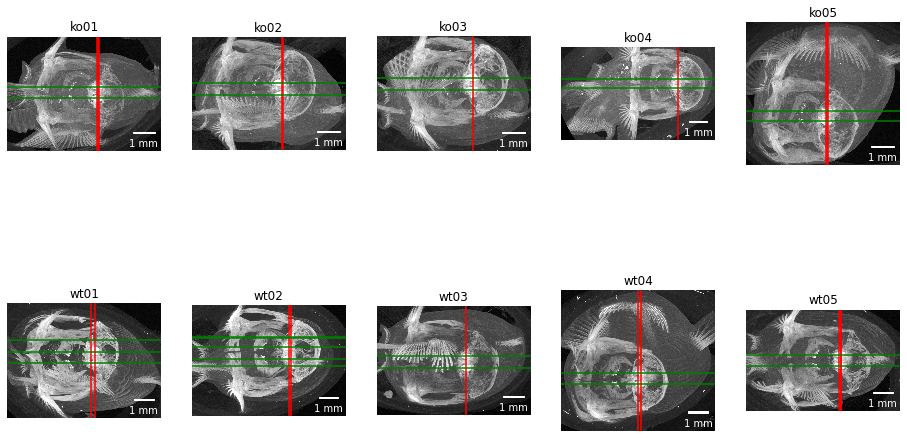

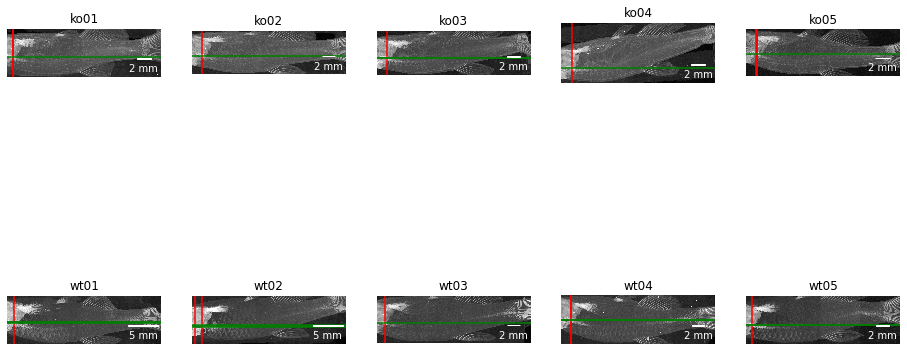

In [146]:
# Preview what we found
for d, direction in enumerate(directions):
    for c, row in Data.iterrows():
        plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
        plt.imshow(row['MIP_' + direction], vmax=150)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title(row['Sample'])
        plt.axis('off')
        for i in row['Otholith_' + direction][0]:
            plt.axvline(i, c='r')
        for i in row['Otholith_' + direction][1]:
            plt.axhline(i, c='g')    
    plt.show()

In [39]:
import statsmodels
def get_oto(curve, verbose=False):
    '''
    Function to detect the start/end of the tailfin.
    Adapted from the 'detect_minima' function from the ZMK tooth cohort notebook (https://git.io/J3qqL)
    Ultimately based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    # Smooth the curve and look for the largest deviation
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.025)
    maxima = numpy.argmax(smoothed)
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(maxima, c='r', label='Maximum deviation')
        plt.legend()
        plt.show()
    return(maxima)

In [40]:
def headcutter(whichone, sigma=5, threshold=150, verbose=False):
    '''
    Function to detect where the tail is.
    We simply look for peaks in the gray values :)
    '''
    img = Data['MIP_Sagittal'][whichone]
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Project average brightness
    x = numpy.mean(smoothed>threshold, axis=0)
    # Use only the tail-part of the fish
    cut = get_oto(x)
    if verbose:
        plt.imshow(img, vmax=150)
        plt.plot(img.shape[0]/x.max()*0.618*x,c='r')
        plt.axvline(cut)
        plt.axis('off')
        plt.show()
    return(cut)

In [41]:
# Calculate where we crop the head off
Data['HeadCrop'] = [headcutter(i, verbose=False) for i in range(len(Data))]

In [42]:
import statsmodels
def get_minimum(curve, verbose=False):
    '''
    Function to detect the start/end of the tailfin.
    Adapted from the 'detect_minima' function from the ZMK tooth cohort notebook (https://git.io/J3qqL)
    Ultimately based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    # Smooth the curve and look for the largest deviation
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.025)
    maxima = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(maxima, c='r', label='Maximum deviation')
        plt.legend()
        plt.show()
    return(maxima)

In [43]:
def tailcutter(whichone, start=2000, sigma=11, verbose=False):
    '''
    Function to detect where the tail is.
    We simply look for peaks in the gray values :)
    '''
    img = Data['MIP_Sagittal'][whichone]
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Project average brightness
    x = numpy.mean(smoothed, axis=0)
    # Use only the tail-part of the fish
    cut = get_minimum(x[start:])
    if verbose:
        plt.imshow(img, vmax=150)
        plt.plot(img.shape[0]/x.max()*0.618*x,c='r')
        plt.axvline(cut+start)
        plt.axis('off')
        plt.show()
    return(cut+start)

In [44]:
# Calculate where we crop the tail off
Data['TailCrop'] = [tailcutter(i, verbose=False) for i in range(len(Data))]

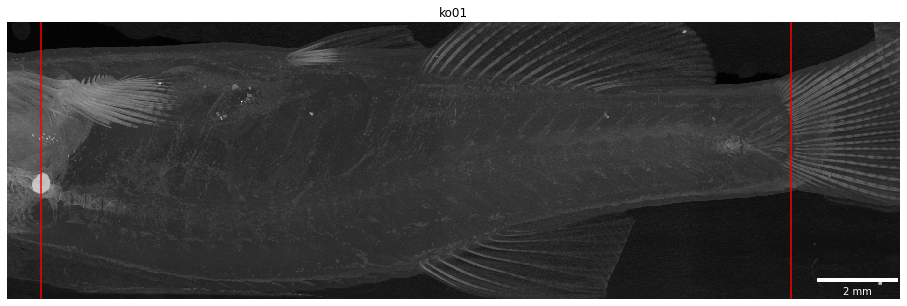

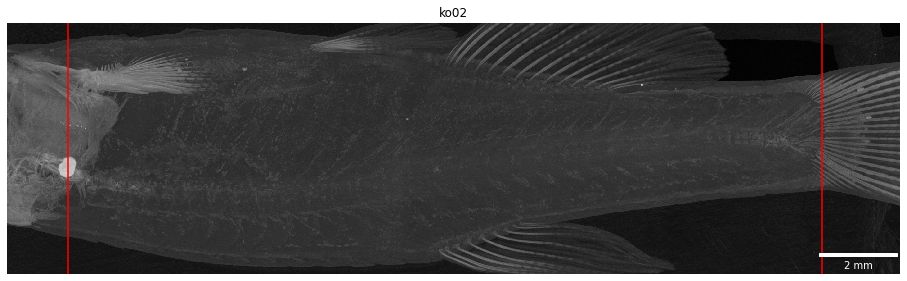

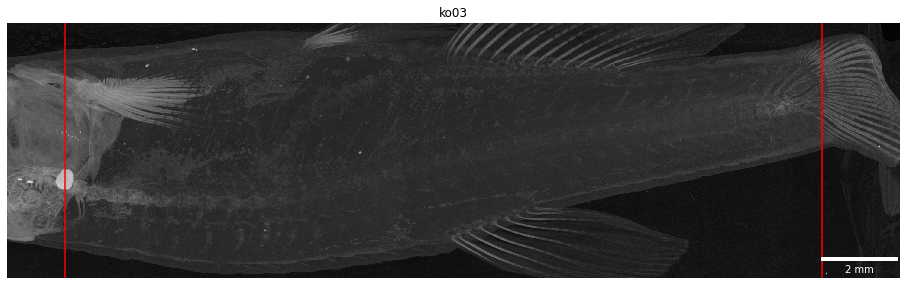

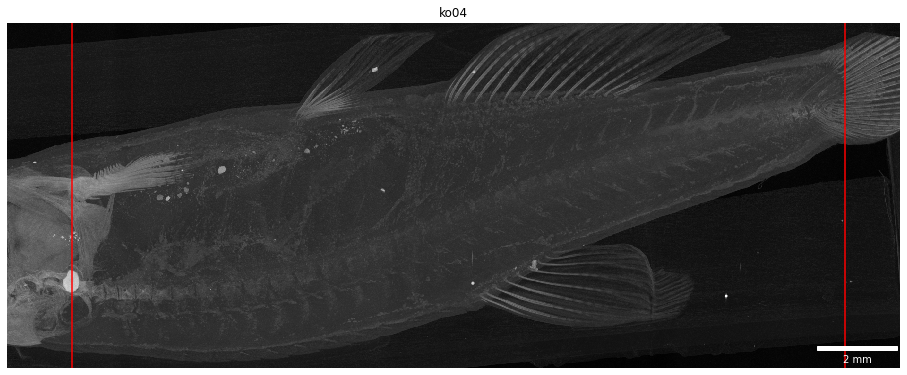

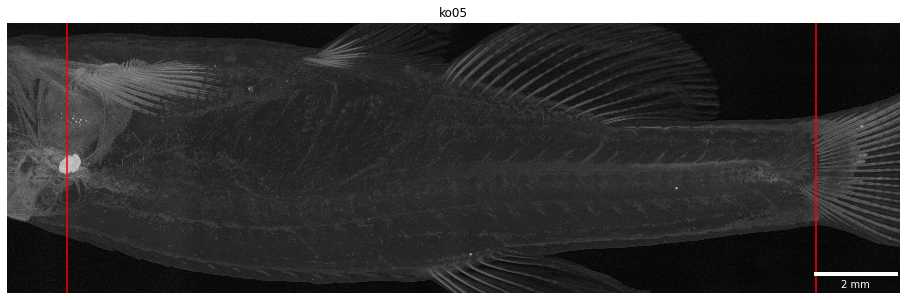

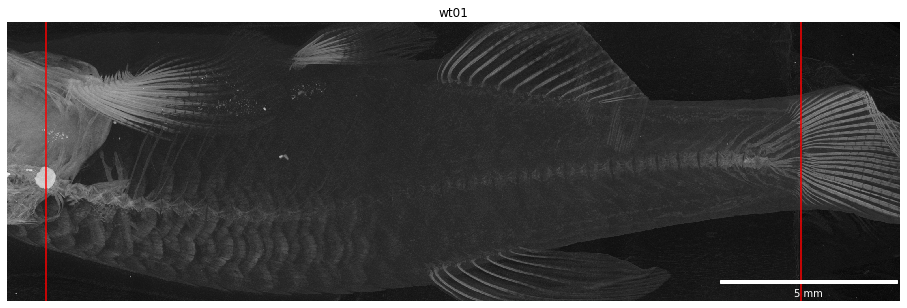

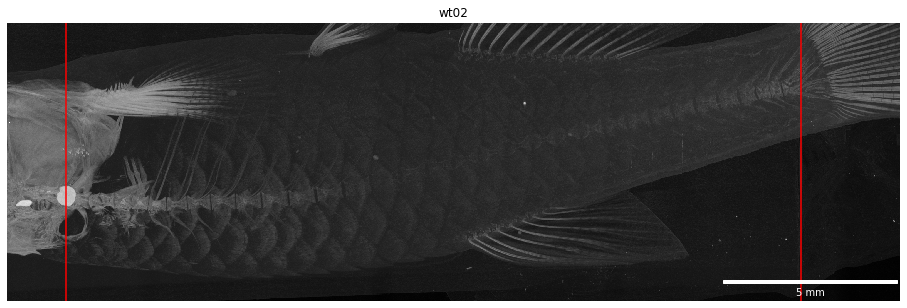

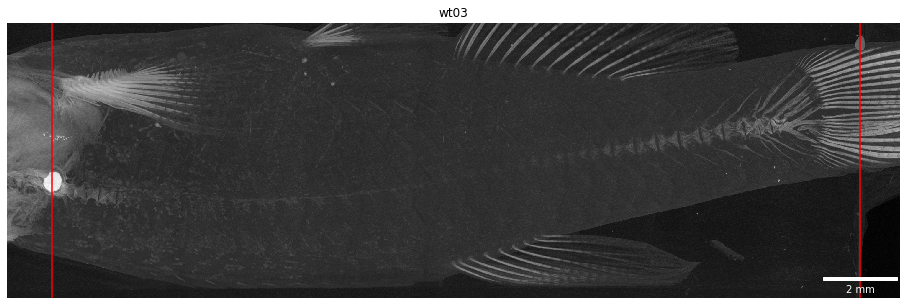

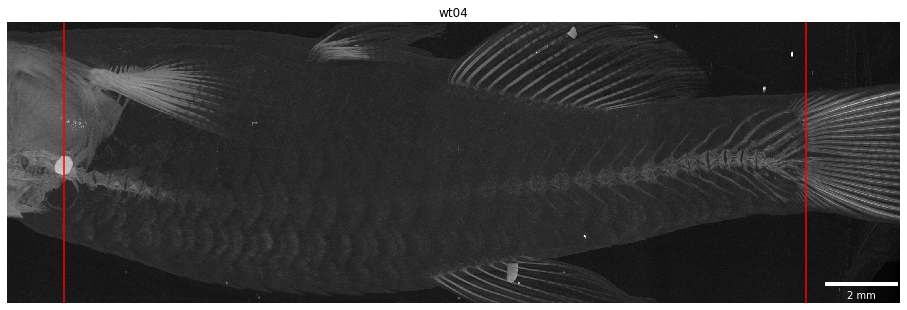

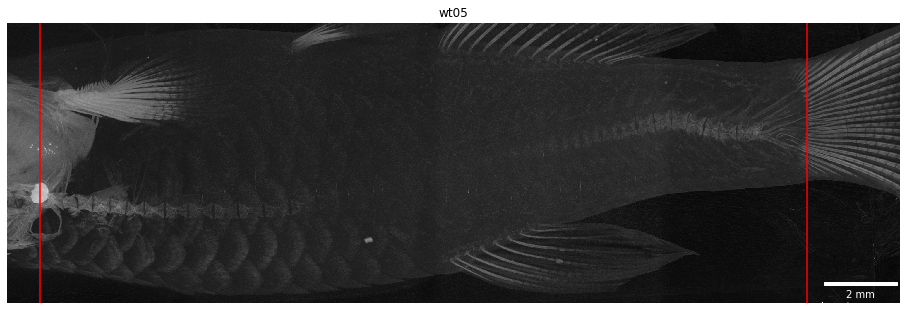

In [45]:
# Show the locations of the crops that we found
for c,row in Data.iterrows():
    plt.imshow(row['MIP_Sagittal'])
    plt.axvline(row.HeadCrop, c='r')
    plt.axvline(row.TailCrop, c='r')
    plt.title(row.Sample)
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.show()

In [ ]:
Reconstructions[4]

In [46]:
# Actually crop the reconstructions down
ReconstructionsCrop = [rec[headcrop:tailcrop] for rec, headcrop, tailcrop in zip(Reconstructions,
                                                                             Data['HeadCrop'],
                                                                                 Data['TailCrop'])]

In [154]:
ReconstructionsCrop[4]

dask.array<getitem, shape=(2261, 756, 816), dtype=uint8, chunksize=(200, 200, 200), chunktype=numpy.ndarray>

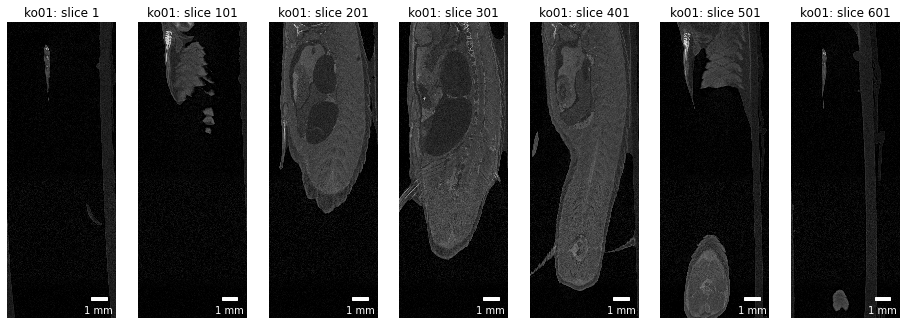

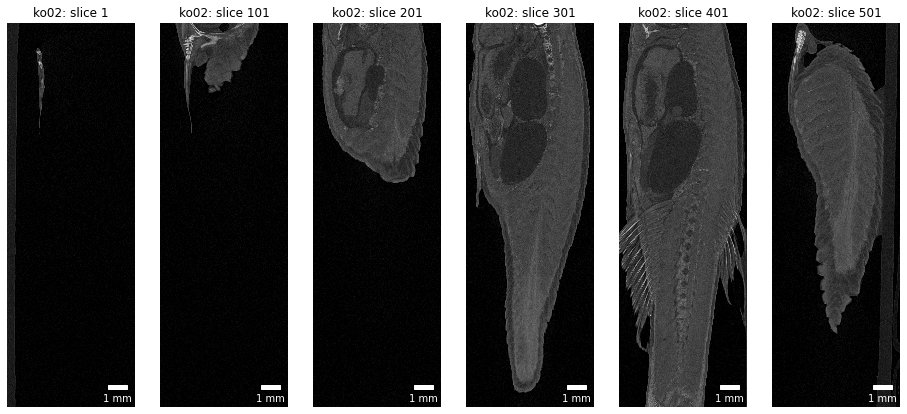

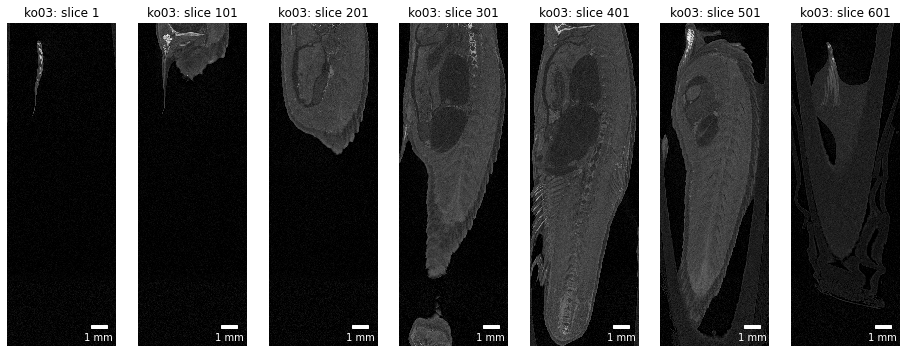

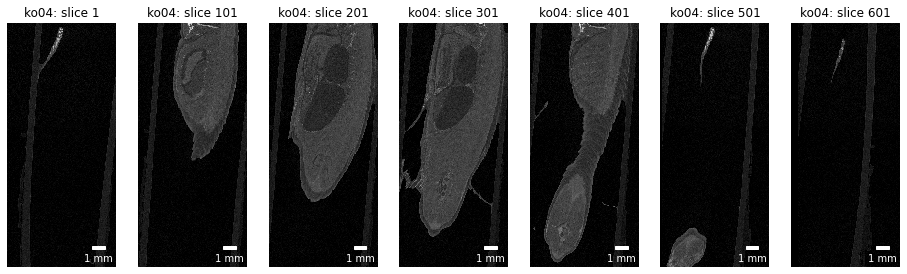

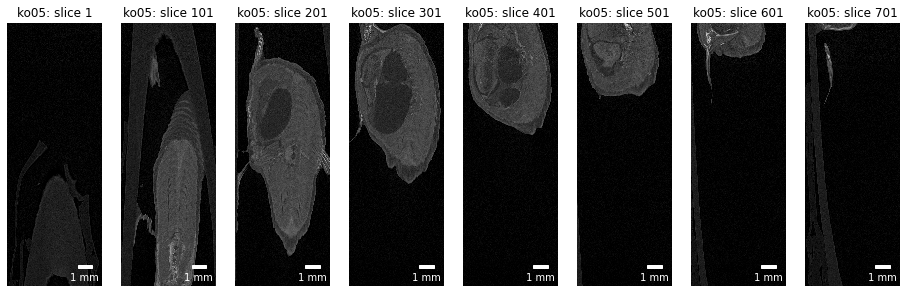

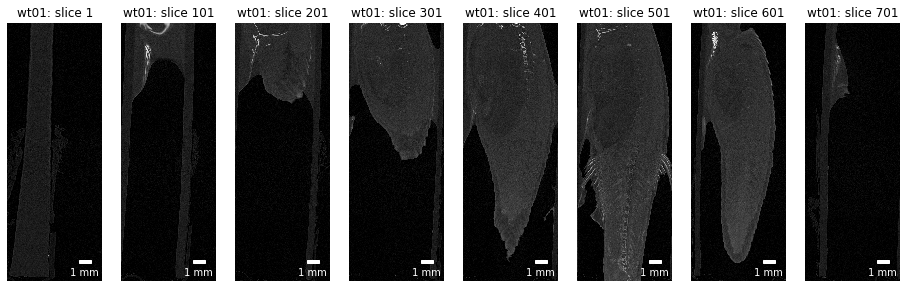

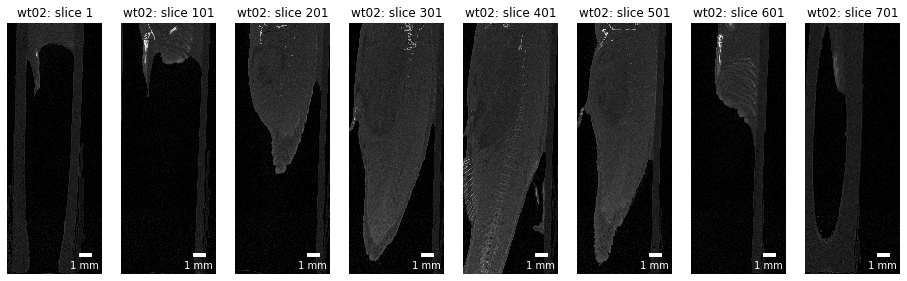

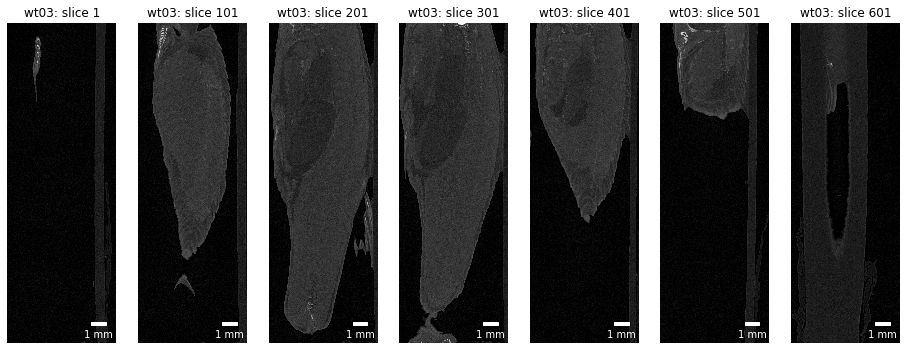

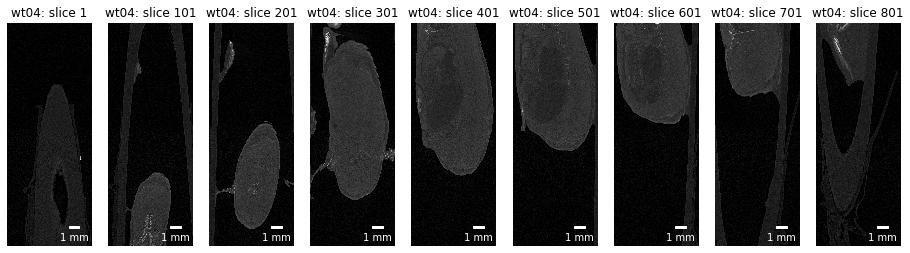

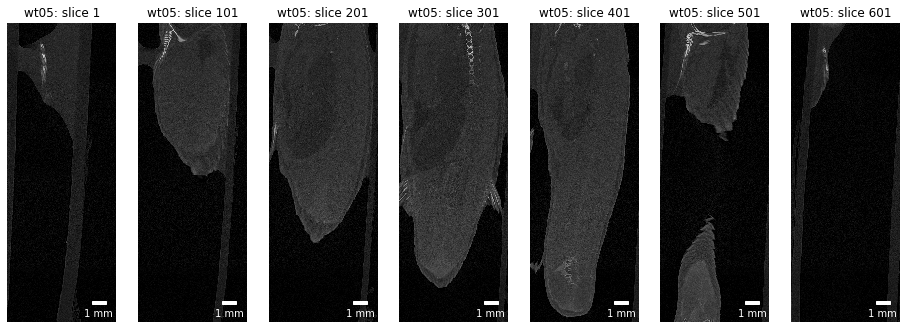

In [155]:
for c, rec in enumerate(ReconstructionsCrop):
    for k,i in enumerate(range(1, rec.shape[1], 100)):
        plt.subplot(1,len(range(1, rec.shape[1], 100)), k+1)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
        plt.imshow(rec[:,i,:], vmax=150)
        plt.axis('off')
        plt.title('%s: slice %s' % (Data['Sample'][c], i))
    plt.show()

In [341]:
# Recalculate the size of the datasets
Data['SizeCrop'] = [rec.shape for rec in ReconstructionsCrop]

In [342]:
# Read or calculate the cropped middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_Crop_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='Cropped middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.Crop.Middle.%s.png' % (row['Sample'],
                                                              direction))
    if os.path.exists(outfilepath):
        Data.at[c, 'Mid_Crop_' + direction] = imageio.imread(outfilepath)
    else:
        # Generate requested axial view
        if 'Transversal' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][Data['SizeCrop'][c][0] // 2]
        if 'Sagittal' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][:, Data['SizeCrop'][c][1] // 2, :]
        if 'Coronal' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][:, :, Data['SizeCrop'][c][2] // 2]
        # Save the calculated 'direction' view to disk
        imageio.imwrite(outfilepath, (Data.at[c, 'Mid_Crop_' + direction]))

Cropped middle images:   0%|          | 0/10 [00:00<?, ?it/s]

Fish ko01:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko02:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko03:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko04:   0%|          | 0/3 [00:00<?, ?it/s]

Fish ko05:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt01:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt02:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt03:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt04:   0%|          | 0/3 [00:00<?, ?it/s]

Fish wt05:   0%|          | 0/3 [00:00<?, ?it/s]

In [343]:
# Read or calculate the cropped directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Crop_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='Calculating cropped MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.Crop.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_Crop_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_Crop_' + direction] = ReconstructionsCrop[c].max(axis=-d)
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_Crop_' + direction].astype('uint8'))

Calculating cropped MIPs:   0%|          | 0/10 [00:00<?, ?it/s]

ko01:   0%|          | 0/3 [00:00<?, ?it/s]

ko02:   0%|          | 0/3 [00:00<?, ?it/s]

ko03:   0%|          | 0/3 [00:00<?, ?it/s]

ko04:   0%|          | 0/3 [00:00<?, ?it/s]

ko05:   0%|          | 0/3 [00:00<?, ?it/s]

wt01:   0%|          | 0/3 [00:00<?, ?it/s]

wt02:   0%|          | 0/3 [00:00<?, ?it/s]

wt03:   0%|          | 0/3 [00:00<?, ?it/s]

wt04:   0%|          | 0/3 [00:00<?, ?it/s]

wt05:   0%|          | 0/3 [00:00<?, ?it/s]

In [344]:
# Calculate the histograms of all reconstructions
# Caveat dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(rec, bins=2**8, range=[0, 2**8]) for rec in ReconstructionsCrop]
# Calculate histogram data and put only h into the dataframe, since we use it quite often below.
# Discard the bins
Data['Histogram'] = [h.compute() for h,b in Data['Histogram']]

In [160]:
def histogramclusterer(img, number_of_clusters = 5, verbose=False):
    '''Calculate the k-means clusters
    Speed things up with MiniBatchKMeans
    https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
    '''
    import sklearn.cluster
    # Setup k-means
    kmeans_volume_subset = sklearn.cluster.MiniBatchKMeans(number_of_clusters)
    # Cluster the histogram into the requested numer of clusters
    # Do this on a subset of the images, to speed things up
    ClusteredImg = kmeans_volume_subset.fit_predict(sorted(numpy.array(img).reshape(-1,1)))
    # Reshape image
    ClusteredImg.shape = img.shape
    if verbose:
        # Calculate histogram
        histogram, bins = dask.array.histogram(img, bins=2**8, range=[0, 2**8])
        plt.semilogy(numpy.log(histogram), label='Gray value histogram')
        plt.semilogy(histogram, label='Gray value histogram (log)')
        for c, cluster in enumerate(sorted(kmeans_volume_subset.cluster_centers_.squeeze())):
            plt.axvline(cluster, label='Cluster center %s at %0.0f' % (c,  cluster),
                        color=seaborn.color_palette(n_colors=number_of_clusters)[c])
        plt.legend()
        plt.xlim([0,2**8])
        plt.title('Logarithmic histogram of input image with %s cluster centers' % number_of_clusters)
        plt.show()
    return(sorted(kmeans_volume_subset.cluster_centers_.squeeze()))

In [ ]:
Data['ClusterCenters'] = [histogramclusterer(rec[::200], verbose=False) for rec in ReconstructionsCrop]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by 

AttributeError: 'Series' object has no attribute 'ClusterCenters'

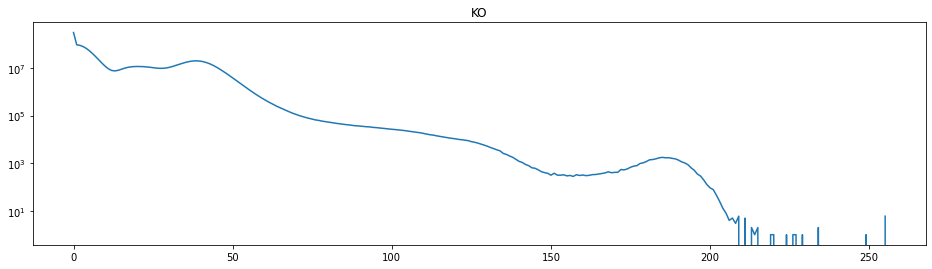

In [345]:
# Histograms per experiment
for c, experiment in enumerate(Data.Experiment.unique()):
    plt.subplot(2,1,c+1)
    plt.title(experiment)
    for c,row in Data[Data.Experiment == experiment].iterrows():
        plt.semilogy(row.Histogram,
                     label=row.Sample,
                     color=seaborn.color_palette(n_colors=len(Data))[c])
        for cc in row.ClusterCenters:
            plt.axvline(cc,
                        color=seaborn.color_palette(n_colors=len(Data))[c],
                        alpha=.616)
    plt.xlim([0,2**8])
    plt.legend()
plt.savefig(os.path.join(OutPutDir, 'Histograms.Experiment.ClusterCenters.png'))   
plt.show()

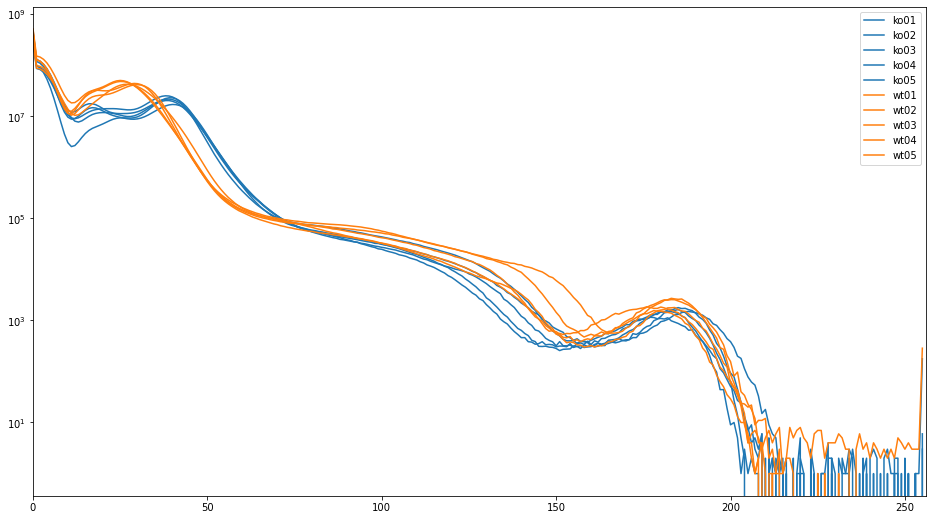

In [346]:
# All histograms, colored per experiment
for c,row in Data.iterrows():
    color=0
    if row.Experiment=='WT':
        color=1
    plt.semilogy(row.Histogram,
                 label=row.Sample,
                 color=seaborn.color_palette(n_colors=2)[color])
plt.xlim([0,2**8])
plt.legend()
plt.savefig(os.path.join(OutPutDir, 'Histograms.Experiment.png'))
plt.show()

In [ ]:
iterator = 500
for c, clustercntr in enumerate(Data['ClusterCenters']):
    print('-----Sample %s----' % Data['Sample'][c])
    for imgnr, image in enumerate(ReconstructionsCrop[c][::iterator]):
        for d, threshold in enumerate(clustercntr):
            plt.subplot(1,len(clustercntr), d+1)
            plt.imshow(image)
            plt.imshow(image<threshold, cmap='viridis', alpha=0.5)
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
            plt.title('%s\nThreshold %s' % (os.path.basename(row.Reconstructions[row.HeadCrop:row.TailCrop][::iterator][imgnr]),
                                            round(threshold, 2)))
            plt.axis('off')
        plt.show()

In [347]:
# Apply a median filter to the cropped reconstructions
import dask_image.ndfilters
ReconstructionsMedian = [dask_image.ndfilters.median_filter(rec, size=5) for rec in ReconstructionsCrop]

In [348]:
# Write out median-filtered reconstructions to zarr
Data['OutputNameMedian'] = [os.path.join(os.path.dirname(f),
                                         fish + '_rec_median.zarr') for f, fish in zip(Data['Folder'],
                                                                                       Data['Sample'])]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out median-filtered recs to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameMedian']):
        ReconstructionsMedian[c].rechunk(chunks=200).to_zarr(row['OutputNameMedian'],
                                                             overwrite=True,
                                                             compressor=Blosc(cname='zstd',
                                                                              clevel=9,
                                                                              shuffle=Blosc.BITSHUFFLE))

Saving out median-filtered recs to .zarr:   0%|          | 0/10 [00:00<?, ?it/s]

In [349]:
# Load them back in
ReconstructionsMedian = [dask.array.from_zarr(file) for file in Data['OutputNameMedian']]            

In [350]:
# Calculate the histograms of median-filtered reconstructions
Data['HistogramMedian'] = [dask.array.histogram(rec, bins=2**8, range=[0, 2**8]) for rec in ReconstructionsMedian]
Data['HistogramMedian'] = [h.compute() for h,b in Data['HistogramMedian']]

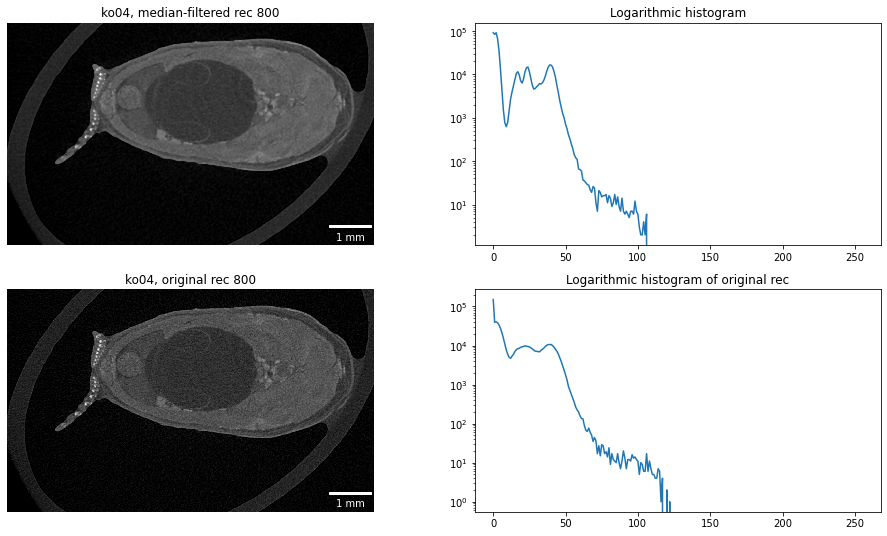

In [351]:
# Show what we did there
whichsample = 3
whichslice = 800
plt.subplot(221)
plt.imshow(ReconstructionsMedian[whichsample][whichslice])
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichsample], 'um'))
plt.title('%s, median-filtered rec %s' % (Data.Sample[whichsample], whichslice))
plt.subplot(222)
plt.semilogy(dask.array.histogram(ReconstructionsMedian[whichsample][whichslice], bins=2**8, range=[0, 2**8])[0])
plt.title('Logarithmic histogram')
plt.subplot(223)
plt.imshow(ReconstructionsCrop[whichsample][whichslice])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichsample], 'um'))
plt.title('%s, original rec %s' % (Data.Sample[whichsample], whichslice))
plt.axis('off')
plt.subplot(224)
plt.semilogy(dask.array.histogram(ReconstructionsCrop[whichsample][whichslice], bins=2**8, range=[0, 2**8])[0])
plt.title('Logarithmic histogram of original rec')
plt.show()

In [ ]:
Data['ClusterCentersMedian'] = [histogramclusterer(rec[::200], verbose=False) for rec in ReconstructionsMedian]

AttributeError: 'Series' object has no attribute 'ClusterCentersMedian'

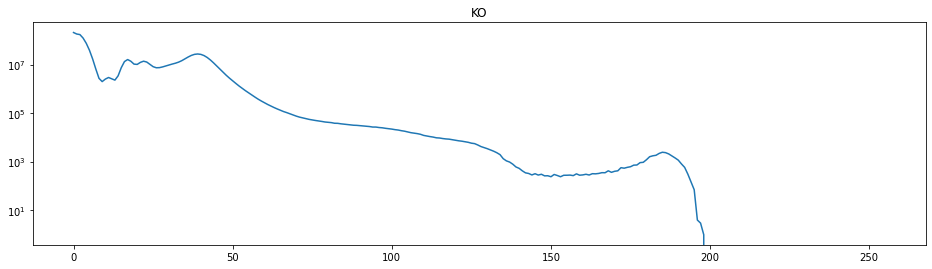

In [353]:
# Histograms of median data per experiment
for c, experiment in enumerate(Data.Experiment.unique()):
    plt.subplot(2,1,c+1)
    plt.title(experiment)
    for c,row in Data[Data.Experiment == experiment].iterrows():
        plt.semilogy(row.HistogramMedian,
                     label=row.Sample,
                     color=seaborn.color_palette(n_colors=len(Data))[c])
        for cc in row.ClusterCentersMedian:
            plt.axvline(cc,
                        color=seaborn.color_palette(n_colors=len(Data))[c],
                        alpha=.616)
    plt.xlim([0,2**8])
    plt.legend()
plt.savefig(os.path.join(OutPutDir, 'Histograms.Median.Experiment.ClusterCenters.png'))   
plt.show()

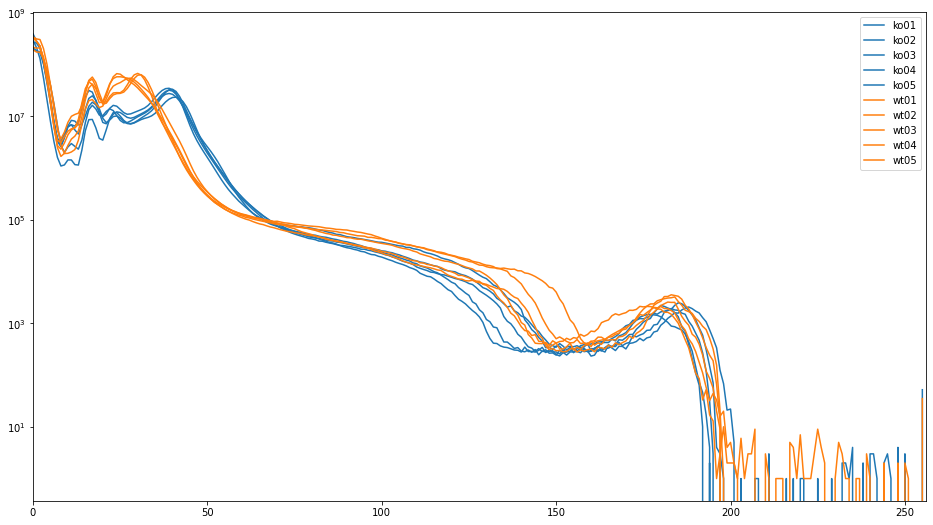

In [375]:
# All median histograms, colored per experiment
for c,row in Data.iterrows():
    color=0
    if row.Experiment=='WT':
        color=1
    plt.semilogy(row.HistogramMedian,
                 label=row.Sample,
                 color=seaborn.color_palette(n_colors=2)[color])
plt.xlim([0,2**8])
plt.legend()
plt.savefig(os.path.join(OutPutDir, 'Histograms.Median.Experiment.png'))
plt.show()

In [728]:
# Calculate peaks of all histograms, we use them for the segmentation afterwards
Data['Peaks'] = [scipy.signal.find_peaks(h,prominence=[777, None]) for h in Data['Histogram']]
Data['Peaks'] = [numpy.ma.masked_less(p,23).compressed() for p,details in Data['Peaks']]

In [729]:
Data['Peaks']

0         [38, 185]
1     [25, 39, 182]
2    [38, 182, 185]
3         [39, 188]
4         [40, 177]
5         [25, 183]
6         [25, 183]
7         [30, 184]
8         [29, 178]
9         [27, 176]
Name: Peaks, dtype: object

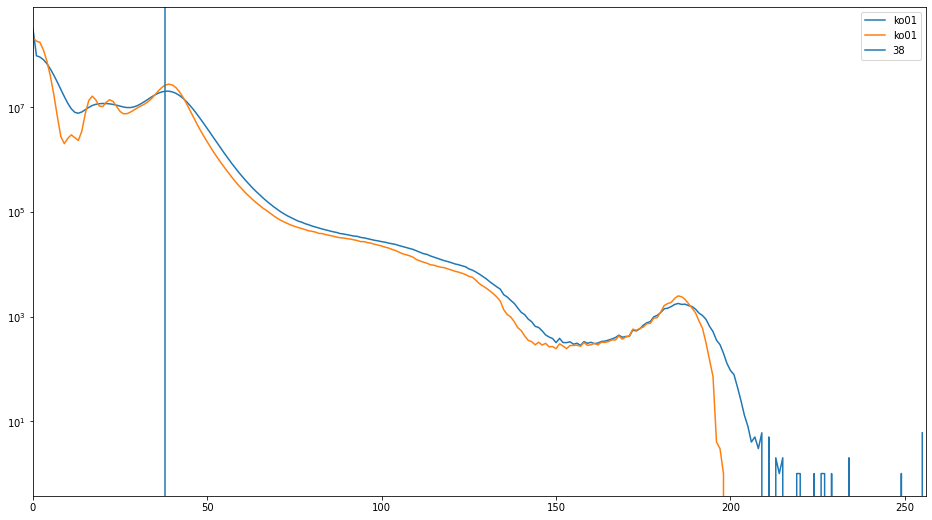

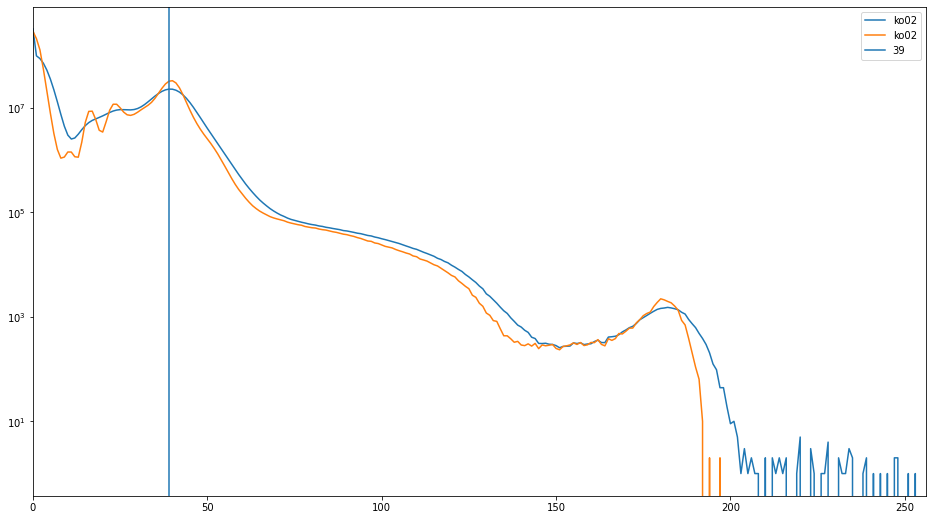

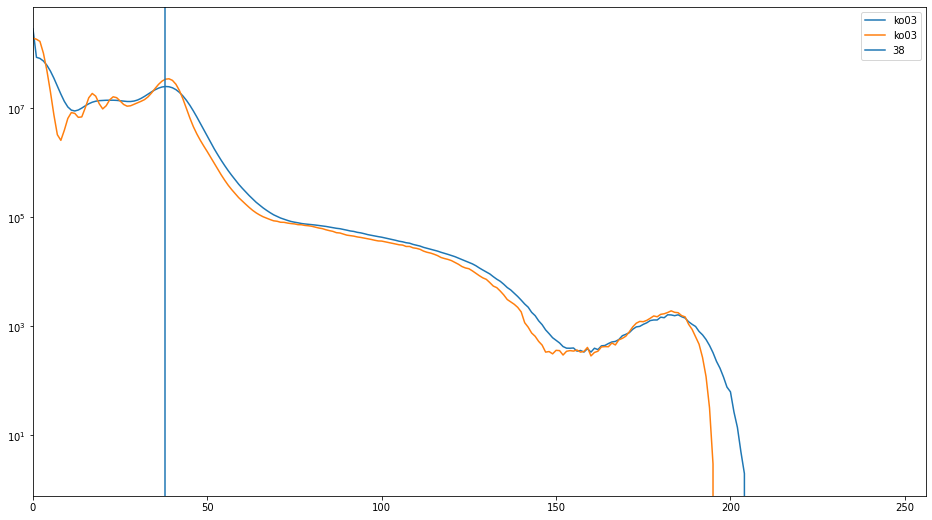

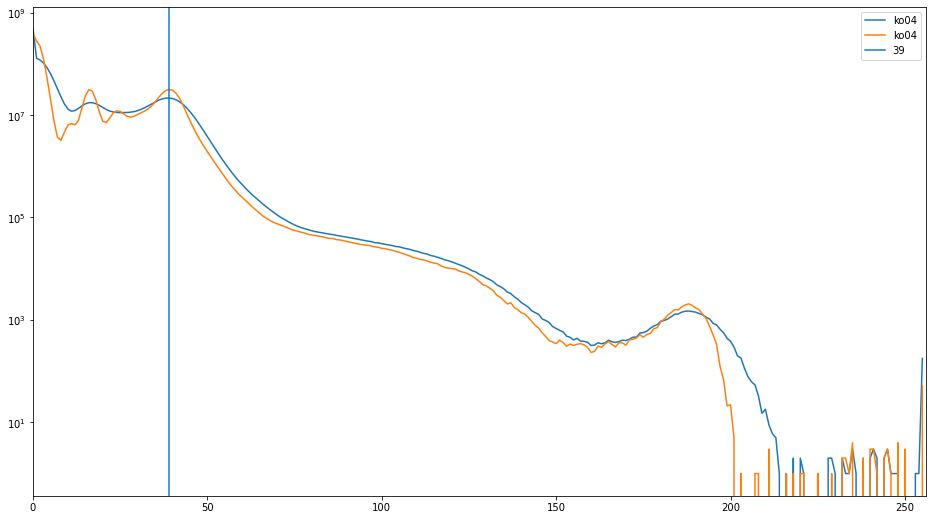

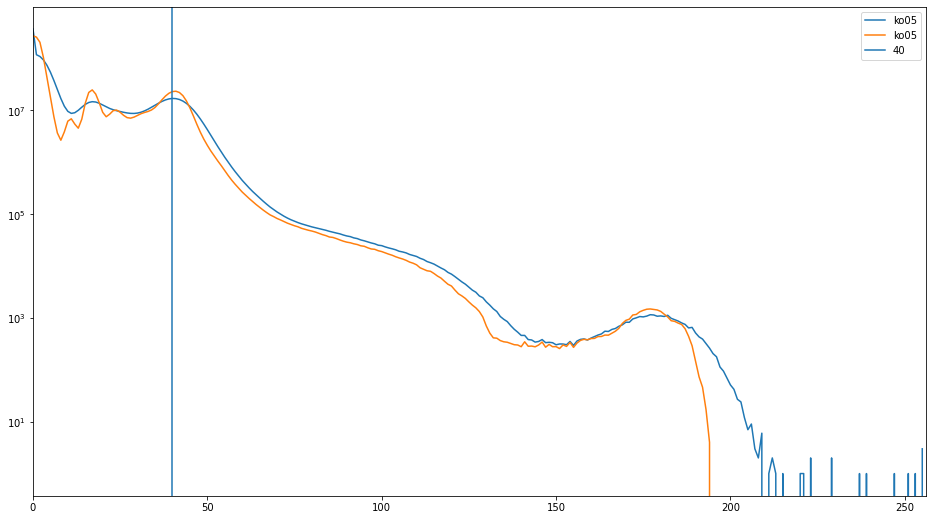

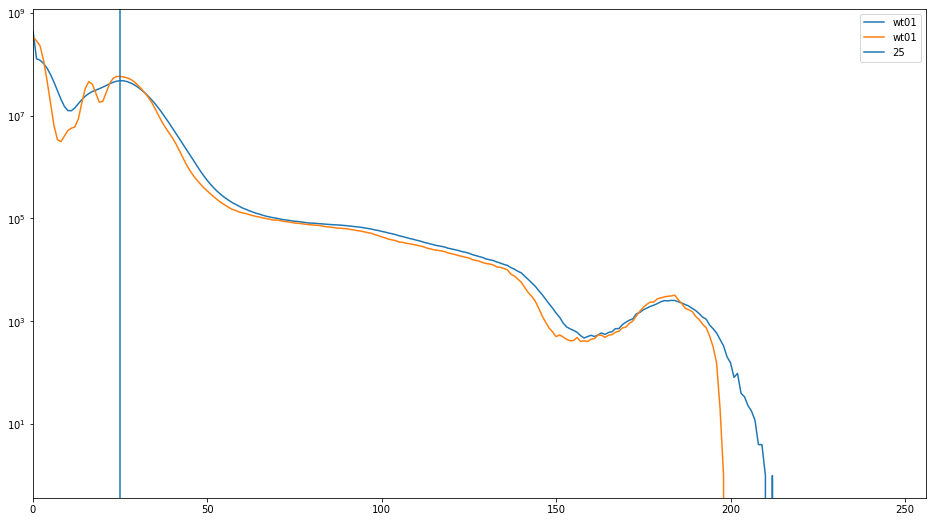

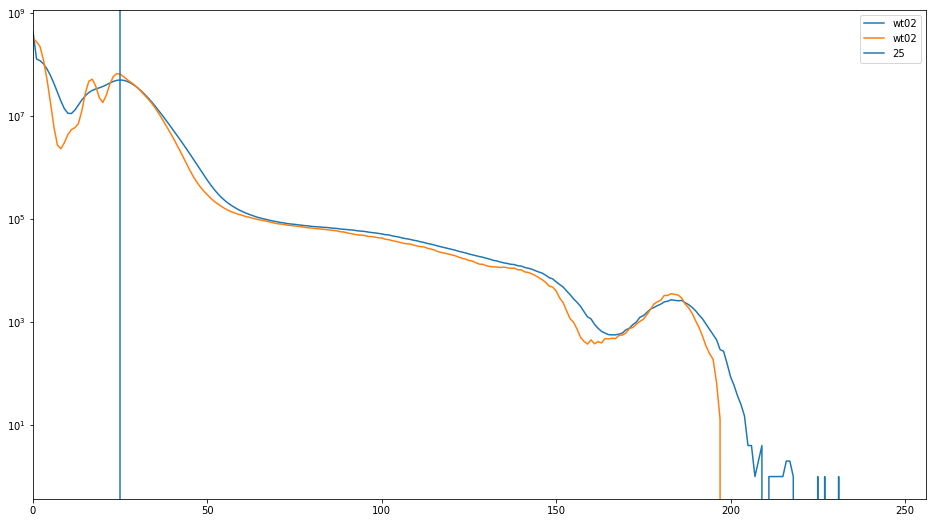

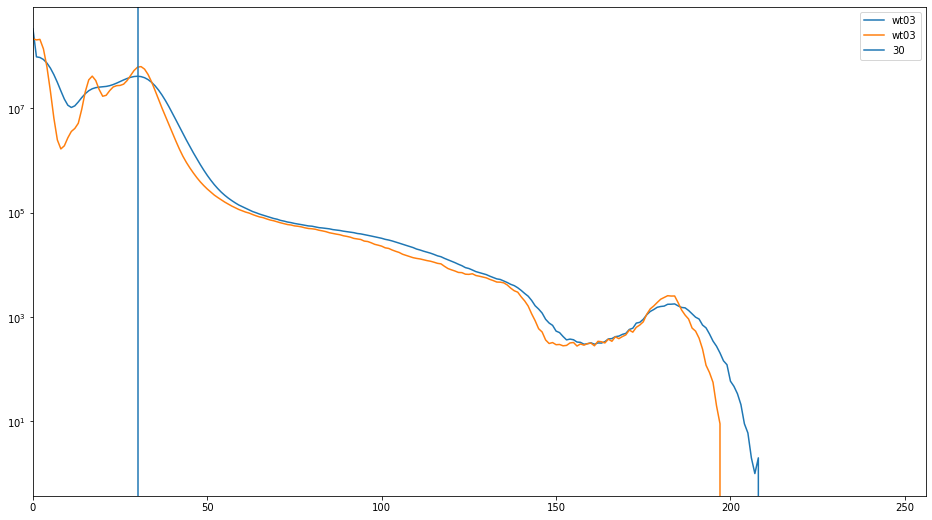

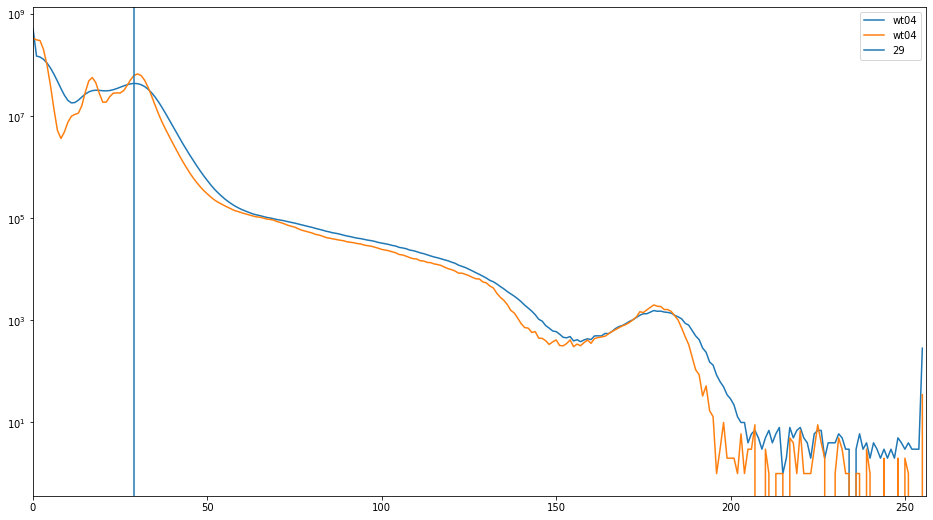

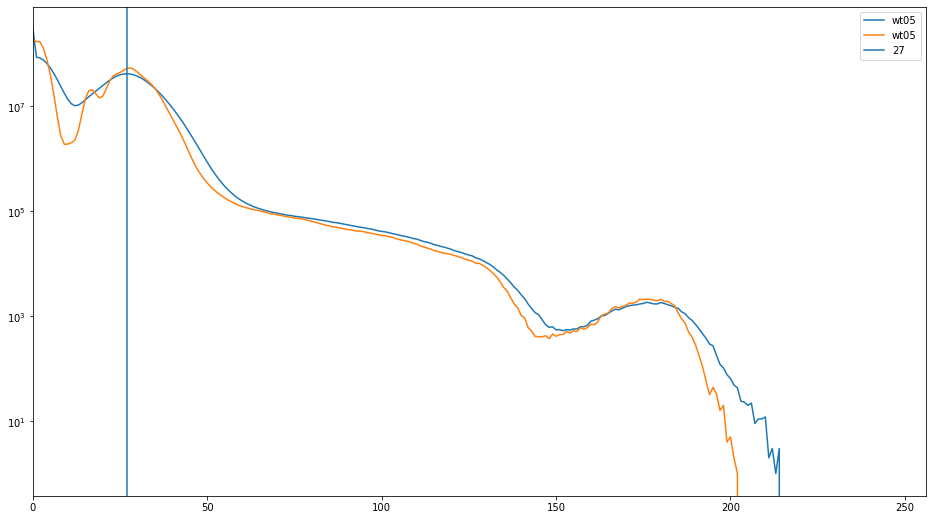

In [548]:
# All median histograms, colored per experiment
for c,row in Data.iterrows():
    color=0
    if row.Experiment=='WT':
        color=1
    plt.semilogy(row.Histogram,
                 label=row.Sample,
                 color=seaborn.color_palette(n_colors=3)[0])
    plt.semilogy(row.HistogramMedian,
                 label=row.Sample,
                 color=seaborn.color_palette(n_colors=3)[1])    
    #Plot them peaks
    for p in row.Peaks:
        plt.axvline(p, label=p, color=seaborn.color_palette(n_colors=3)[0])
    plt.xlim([0,2**8])
    plt.legend()
    plt.show()

In [550]:
# Write out median filtered reconstructions   
for c, row in notebook.tqdm(Data.iterrows(), desc='Writing median-filtered reconstructions', total=len(Data)):
    # Generate output folder
    os.makedirs(os.path.join(os.path.dirname(row.Folder), 'rec_median'), exist_ok=True)
    # For every reconstructions, load it's median-filtered counterpart
    # But only do this for the relevant filenames, e.g. those between the crops :)
    for d, name in notebook.tqdm(enumerate(row.Reconstructions[row.HeadCrop:row.TailCrop]),
                                 total=len(ReconstructionsMedian[c]),
                                 leave=False):
        filename = name.replace('rec', 'rec_median')
        if not os.path.exists(filename):
            imageio.imwrite(filename, ReconstructionsMedian[c][d])

Writing median-filtered reconstructions:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2355 [00:00<?, ?it/s]

  0%|          | 0/2433 [00:00<?, ?it/s]

  0%|          | 0/2504 [00:00<?, ?it/s]

  0%|          | 0/2411 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2671 [00:00<?, ?it/s]

  0%|          | 0/2641 [00:00<?, ?it/s]

  0%|          | 0/2740 [00:00<?, ?it/s]

  0%|          | 0/2570 [00:00<?, ?it/s]

  0%|          | 0/2622 [00:00<?, ?it/s]

In [739]:
from skimage.segmentation import random_walker
def segmentor(image, peaks, verbose=False):
    # https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html#sphx-glr-auto-examples-segmentation-plot-random-walker-segmentation-py
    markers = numpy.zeros_like(image, dtype=np.uint)
    markers[image < peaks[0]] = 1
    markers[image > peaks[0]] = 2
    markers[image > peaks[1]] = 0
    labels = random_walker(image, markers, beta=500)
    if verbose:
        plt.figure()
        plt.subplot(131)
        plt.imshow(image)
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(markers)
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(labels)
        plt.axis('off')
    return(labels.astype('uint8'))

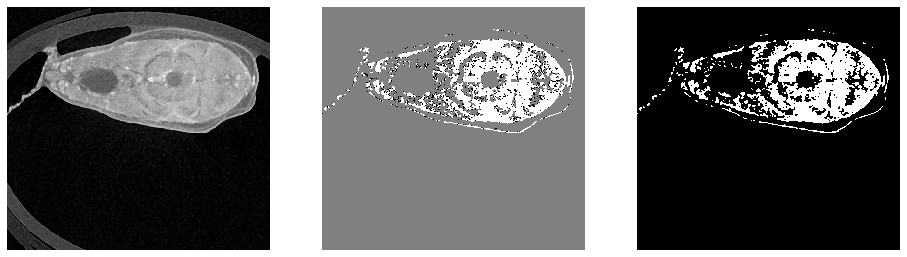

In [740]:
whichsample = 4
whichslice = 999
_ = segmentor(ReconstructionsMedian[whichsample][whichslice].compute(), Data.Peaks[whichsample], verbose=True)

In [742]:
# Write out randon-walker-segmented median filtered reconstructions
for c, row in notebook.tqdm(Data.iterrows(), desc='Writing random-walker segmentation', total=len(Data)):
    # Generate output folder
    os.makedirs(os.path.join(os.path.dirname(row.Folder), 'rec_median_segmented'), exist_ok=True)
    # For every reconstructions, load it's median-filtered counterpart, random-walker-segment it and write it out
    # But only do this for the relevant filenames, e.g. those between the crops :)
    for d, name in notebook.tqdm(enumerate(row.Reconstructions[row.HeadCrop:row.TailCrop]),
                                 total=len(ReconstructionsMedian[c]),
                                leave=False):
        filename = name.replace('rec', 'rec_median_segmented')
        if not os.path.exists(filename):
            imageio.imwrite(filename, segmentor(ReconstructionsMedian[c][d], row.Peaks))

Writing random-walker segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2355 [00:00<?, ?it/s]

  0%|          | 0/2433 [00:00<?, ?it/s]

  0%|          | 0/2504 [00:00<?, ?it/s]

  0%|          | 0/2411 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2671 [00:00<?, ?it/s]

  0%|          | 0/2641 [00:00<?, ?it/s]

  0%|          | 0/2740 [00:00<?, ?it/s]

  0%|          | 0/2570 [00:00<?, ?it/s]

  0%|          | 0/2622 [00:00<?, ?it/s]

In [743]:
# Convert segmented slices to zarr
Data['OutputNameSegmented'] = [os.path.join(os.path.dirname(f),
                                      fish + '_rec_median_segmented.zarr') for f, fish in zip(Data['Folder'],
                                                                                              Data['Sample'])]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting segmented slices to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameSegmented']):
        print('%2s/%2s: Reading %s slices and saving to %s' % (c + 1,
                                                               len(Data),
                                                               row['Number of reconstructions'],
                                                               row['OutputNameSegmented'][len(Root)+1:]))
        Segmented = dask_image.imread.imread(os.path.join(row.Folder.replace('rec', 'rec_median_segmented'),
                                                                '*rec*.png'))       
        Segmented.rechunk(chunks=200).to_zarr(row['OutputNameSegmented'],
                                              overwrite=True,
                                              compressor=Blosc(cname='zstd',
                                                               clevel=9,
                                                               shuffle=Blosc.BITSHUFFLE))

Converting segmented slices to .zarr:   0%|          | 0/10 [00:00<?, ?it/s]

 1/10: Reading 2804 slices and saving to ko01\ko01_rec_median_segmented.zarr
 2/10: Reading 2878 slices and saving to ko02\ko02_rec_median_segmented.zarr
 3/10: Reading 2955 slices and saving to ko03\ko03_rec_median_segmented.zarr
 4/10: Reading 2783 slices and saving to ko04\ko04_rec_median_segmented.zarr
 5/10: Reading 2696 slices and saving to ko05\ko05_rec_median_segmented.zarr
 6/10: Reading 3156 slices and saving to wt01\wt01_rec_median_segmented.zarr
 7/10: Reading 3211 slices and saving to wt02\wt02_rec_median_segmented.zarr
 8/10: Reading 3027 slices and saving to wt03\wt03_rec_median_segmented.zarr
 9/10: Reading 3094 slices and saving to wt04\wt04_rec_median_segmented.zarr
10/10: Reading 3051 slices and saving to wt05\wt05_rec_median_segmented.zarr


In [744]:
# Load the (segmented) slices from zarr arrays
Segmented = [dask.array.from_zarr(file) for file in Data['OutputNameSegmented']]

Background: 610965 px
Segmented: 90587 px
Image size: 652 px x 1076 px = 701552 px - 90587 px segmented = 610965 px background


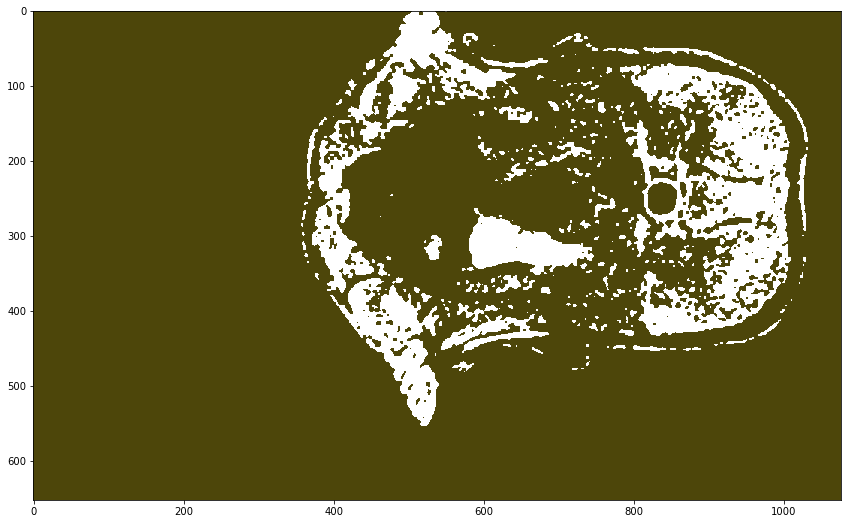

In [745]:
# Let's see what we did there
whichsample = 3
whichslice = 100

# Show image
plt.imshow(Segmented[whichsample][whichslice])
plt.imshow(dask.array.ma.masked_equal(Segmented[whichsample][whichslice],2), alpha=0.309, cmap='viridis_r')

# Output counts
print('Background: %s px' % dask.array.ma.masked_equal(Segmented[whichsample][whichslice], 2).sum().compute())
print('Segmented: %s px' % dask.array.ma.masked_equal(Segmented[whichsample][whichslice], 2).compute().mask.sum())
print('Image size: %s px x %s px = '
      '%s px - %s px segmented = '
      '%s px background' % (Segmented[whichsample][whichslice].shape[0],
                            Segmented[whichsample][whichslice].shape[1],
                            Segmented[whichsample][whichslice].shape[0] * Segmented[whichsample][whichslice].shape[1],
                            dask.array.ma.masked_equal(Segmented[whichsample][whichslice], 2).compute().mask.sum(),
                            Segmented[whichsample][whichslice].shape[0] * Segmented[whichsample][whichslice].shape[1] - dask.array.ma.masked_equal(Segmented[whichsample][whichslice], 2).compute().mask.sum()))
# So we can 'just' sum the masked segmented data correctly :)

In [746]:
# Mask everything that was *not* segmented and calculate the sum of this volume
Data['SegmentedVolume'] = [dask.array.ma.masked_equal(s, 2).compute().mask.sum() for s in Segmented]

In [747]:
# Plot the stuff
Data['SegmentedVolume']

0    177488766
1    364750685
2    187431860
3    155653584
4    134686066
5    439296832
6    420288951
7    305856494
8    337438378
9    406509225
Name: SegmentedVolume, dtype: int64

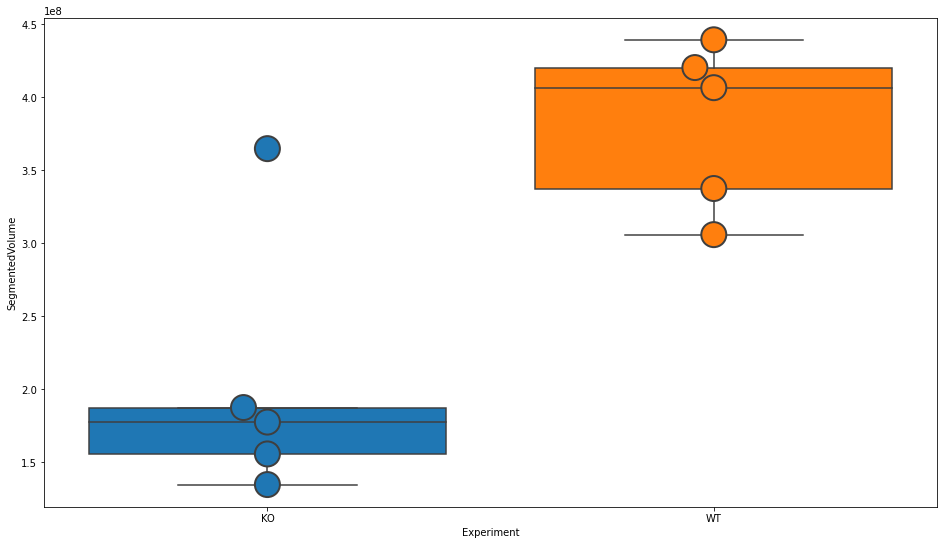

In [754]:
seaborn.boxplot(data=Data,x='Experiment', y='SegmentedVolume', saturation=1)
seaborn.swarmplot(data=Data,x='Experiment', y='SegmentedVolume', s=25, linewidth=2)
plt.savefig(os.path.join(OutPutDir, 'SegmentedVolume.png'))
plt.show()

In [753]:
OutPutDir

'P:\\Documents\\Zebrafish-Carolina\\Output\\16a2e47'

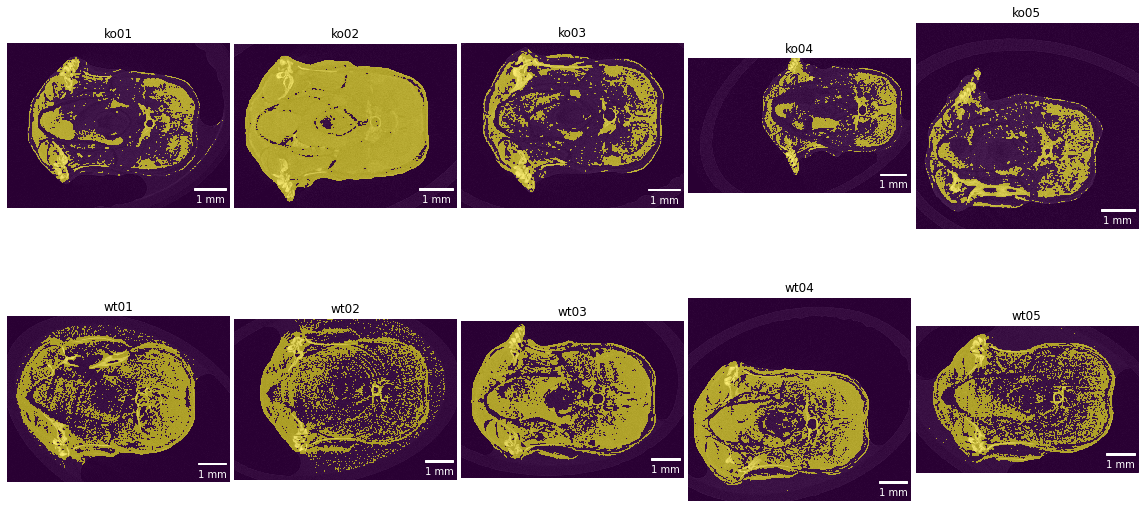

In [756]:
# Does that make sense?
whichslice = 111
for c,row in Data.iterrows():
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(ReconstructionsCrop[c][whichslice])
    plt.imshow(Segmented[c][whichslice], alpha=0.618, cmap='viridis')
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.axis('off')   
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(OutPutDir, 'SegmentedSlices%04d.png' % whichslice))
plt.show()

In [ ]:
asdfasdfasdf==

In [202]:
import itkwidgets
from itkwidgets import view  # 3d viewer

In [204]:
view(Reconstructions[0])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [81]:
seg_explicit_thresholds = sitk.ConnectedThreshold(img_T1,
                                                  seedList=[(600,200)],
                                                  lower=10,
                                                  upper=80)

In [82]:
writer = sitk.ImageFileWriter()
writer.SetFileName('out.png')
writer.Execute(seg_explicit_thresholds)

TypeError: Invalid shape (558992,) for image data

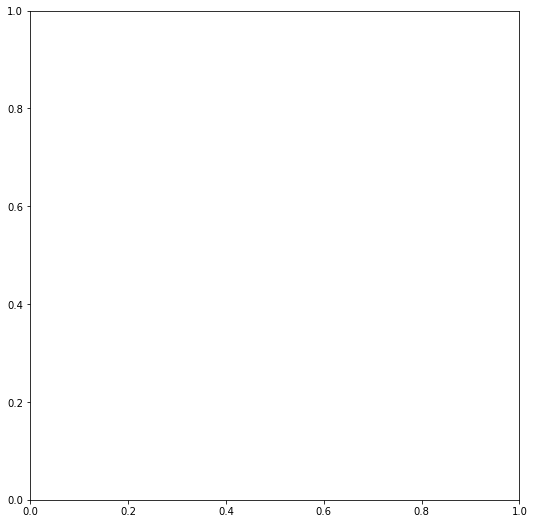

In [68]:
plt.imshow(seg_explicit_thresholds)